In [ ]:
!pip install lightning torchinfo torchshow

In [12]:
import os
from posix import replace
import math
import random
from typing import Callable

from collections import Counter
import lightning as L
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import torchshow as ts
import torchvision
from lightning.pytorch.loggers import TensorBoardLogger
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from torchvision.transforms.v2 import functional as TF
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
from pathlib import Path

from sklearn.model_selection import train_test_split

from PIL import TiffImagePlugin
import tifffile

from google.colab import drive

# Image Classification: EuroSAT Land Use and Land Cover Classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lukas-gysin/bverl-miniproject/blob/main/notebooks/00-submission.ipynb)

Submission of the group **GeoGuesser**
by Julian Steinacher and Lukas Gysin

## Introduction

## Data

The data consists of 27000 datasets containing a label, a RGB Image and a TIF image containing additional 13 Channels. The images are made from a satellite. These datasets are can be found separated on zenodo. They are already delivered in a folder structure where every image is in a folder for their label. Each image has a resolution of 64 by 64. However some channels of the tif image are upsampled to get to this resolution. Each pixel covers 10 meters of land.

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
#[3]
#@title Download MS data set
url = "https://zenodo.org/records/7711810/files/EuroSAT_MS.zip?download=1" #@param {type:"string"}
#@markdown - _Remote source url._
destination_folder = "/content/gdrive/MyDrive" #@param {type:"string"}
#@markdown - _Find folder in gdrive on the left and right-click to copy the path._
filename = "euroSat_ms.zip"

target = f'{destination_folder}/{filename}'
if not os.path.isdir(destination_folder + "/EuroSAT_MS"):
  print("download Files")
  !gdown -O $target "$url"
  !unzip $target -d $destination_folder
  !rm $target

DATA_PATH_MS = destination_folder+"/EuroSAT_MS"
print(DATA_PATH_MS)

/content/gdrive/MyDrive/EuroSAT_MS


In [7]:
import os

#[3]
#@title Download RGB
url = "https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1" #@param {type:"string"}
#@markdown - _Remote source url._
destination_folder = "/content/gdrive/MyDrive" #@param {type:"string"}
#@markdown - _Find folder in gdrive on the left and right-click to copy the path._
filename = "euroSatRgb.zip"


target = f'{destination_folder}/{filename}'
if not os.path.isdir(destination_folder + "/EuroSAT_RGB"):
  print("download Files")
  !gdown -O $target "$url"
  !unzip $target -d $destination_folder
  !rm $target


DATA_PATH_RGB = destination_folder+"/EuroSAT_RGB"
print(DATA_PATH_RGB)

/content/gdrive/MyDrive/EuroSAT_RGB


In [8]:
!find {DATA_PATH_RGB} -type d
!find {DATA_PATH_MS} -type d

/content/gdrive/MyDrive/EuroSAT_RGB
/content/gdrive/MyDrive/EuroSAT_RGB/SeaLake
/content/gdrive/MyDrive/EuroSAT_RGB/Pasture
/content/gdrive/MyDrive/EuroSAT_RGB/River
/content/gdrive/MyDrive/EuroSAT_RGB/PermanentCrop
/content/gdrive/MyDrive/EuroSAT_RGB/Residential
/content/gdrive/MyDrive/EuroSAT_RGB/Industrial
/content/gdrive/MyDrive/EuroSAT_RGB/HerbaceousVegetation
/content/gdrive/MyDrive/EuroSAT_RGB/AnnualCrop
/content/gdrive/MyDrive/EuroSAT_RGB/Highway
/content/gdrive/MyDrive/EuroSAT_RGB/Forest
/content/gdrive/MyDrive/EuroSAT_MS
/content/gdrive/MyDrive/EuroSAT_MS/PermanentCrop
/content/gdrive/MyDrive/EuroSAT_MS/Pasture
/content/gdrive/MyDrive/EuroSAT_MS/Industrial
/content/gdrive/MyDrive/EuroSAT_MS/Residential
/content/gdrive/MyDrive/EuroSAT_MS/Forest
/content/gdrive/MyDrive/EuroSAT_MS/River
/content/gdrive/MyDrive/EuroSAT_MS/Highway
/content/gdrive/MyDrive/EuroSAT_MS/AnnualCrop
/content/gdrive/MyDrive/EuroSAT_MS/SeaLake
/content/gdrive/MyDrive/EuroSAT_MS/HerbaceousVegetation


In [9]:
!find {DATA_PATH_RGB}/Pasture -type f | head -n 5
!find {DATA_PATH_MS}/Pasture -type f | head -n 5

/content/gdrive/MyDrive/EuroSAT_RGB/Pasture/Pasture_1907.jpg
/content/gdrive/MyDrive/EuroSAT_RGB/Pasture/Pasture_647.jpg
/content/gdrive/MyDrive/EuroSAT_RGB/Pasture/Pasture_226.jpg
/content/gdrive/MyDrive/EuroSAT_RGB/Pasture/Pasture_1451.jpg
/content/gdrive/MyDrive/EuroSAT_RGB/Pasture/Pasture_1509.jpg
/content/gdrive/MyDrive/EuroSAT_MS/Pasture/Pasture_1001.tif
/content/gdrive/MyDrive/EuroSAT_MS/Pasture/Pasture_999.tif
/content/gdrive/MyDrive/EuroSAT_MS/Pasture/Pasture_1004.tif
/content/gdrive/MyDrive/EuroSAT_MS/Pasture/Pasture_1005.tif
/content/gdrive/MyDrive/EuroSAT_MS/Pasture/Pasture_1007.tif


The images are divided into 10 labels with each label having at least 2000 datasets:
*  'SeaLake' => 3000 sets
* 'Pasture' => 2000 sets
*  'River' => 2500 sets
* 'PermanentCrop' => 2500 sets
*  'Residential' => 3000 sets
*  'Industrial' => 2500 sets
*  'HerbaceousVegetation' => 3000sets
* 'AnnualCrop' => 3000 sets
* 'Highway' => 2500 sets
* 'Forest' => 3000 sets



Classes: ['SeaLake', 'Pasture', 'River', 'PermanentCrop', 'Residential', 'Industrial', 'HerbaceousVegetation', 'AnnualCrop', 'Highway', 'Forest']
Number of observations: 27000
Counter({'SeaLake': 3000, 'Residential': 3000, 'HerbaceousVegetation': 3000, 'AnnualCrop': 3000, 'Forest': 3000, 'River': 2500, 'PermanentCrop': 2500, 'Industrial': 2500, 'Highway': 2500, 'Pasture': 2000})


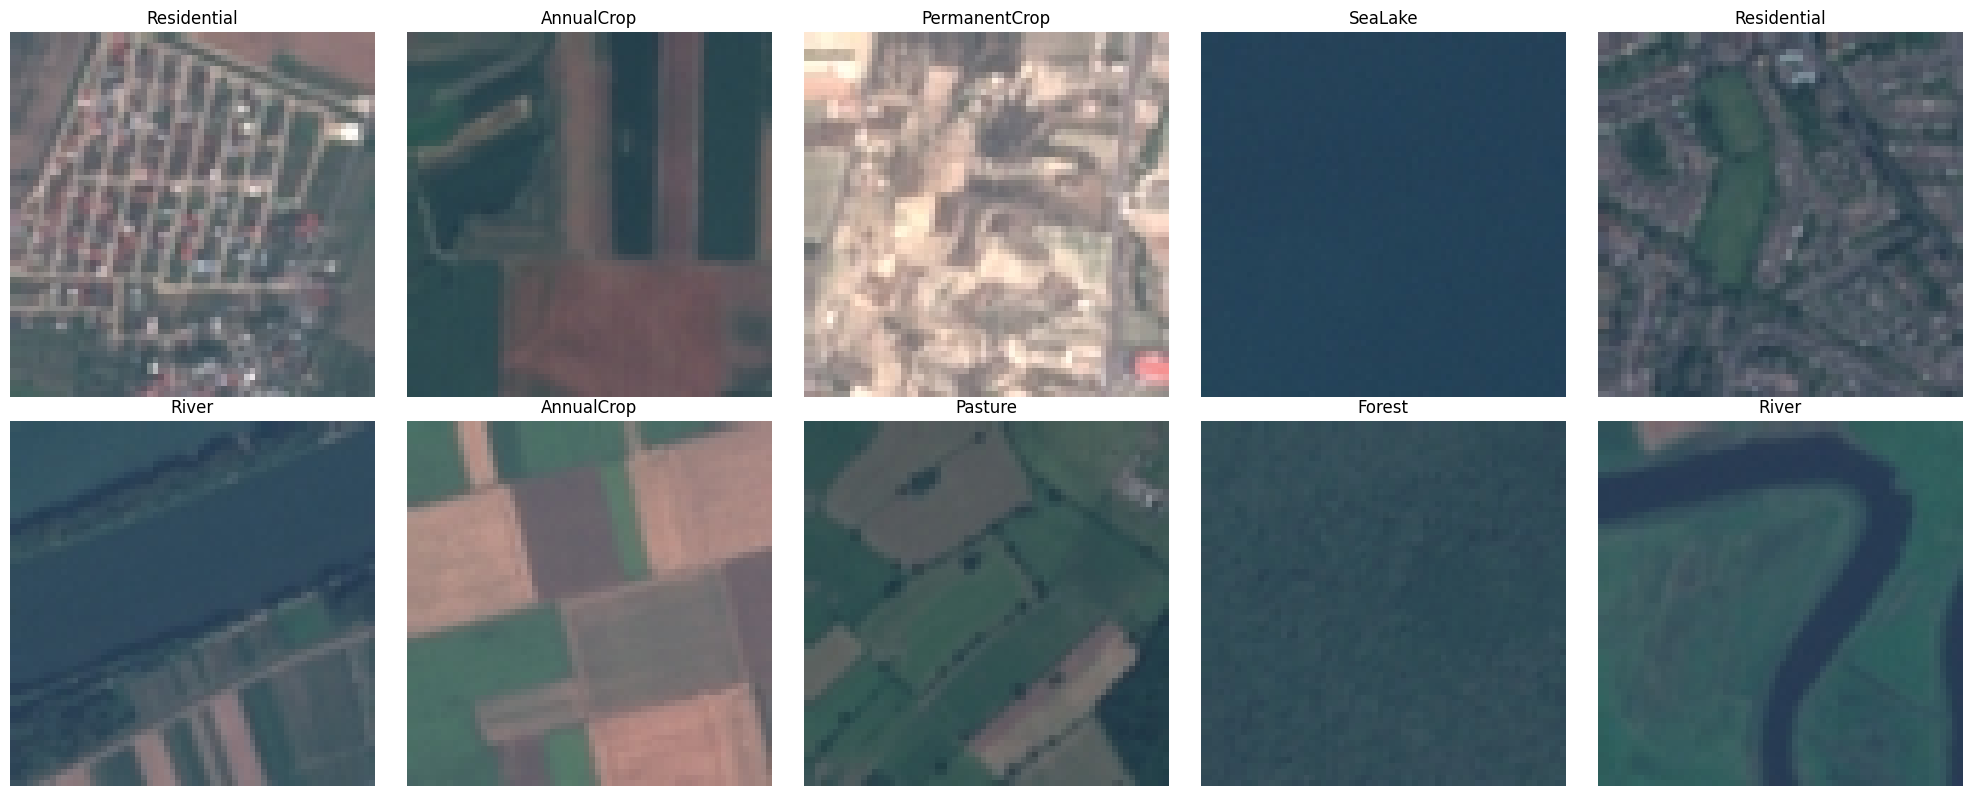

In [11]:
#@title collecting the data

def find_all_eurosat_images(image_dir_rgb: str, image_dir_tif: str) -> list[dict]:
    """
    Load image paths and corresponding labels.

    Args:
        image_dir: Directory with all the images.

    Returns:
        A list of dicts, one for each obsevation
    """
    observations = list()
    classes = os.listdir(image_dir_rgb)
    image_extensions_rgb = {".jpg"}
    image_extensions_tif = {".tif"}
    print(f"Classes: {classes}")
    for label in classes:
        class_dir_rgb = os.path.join(image_dir_rgb, label)
        class_dir_tif = os.path.join(image_dir_tif, label)
        for img_name in os.listdir(class_dir_rgb):
            img_path_rgb = os.path.join(class_dir_rgb, img_name)
            img_path_tif = os.path.join(class_dir_tif, img_name.replace(".jpg", ".tif"))
            if any(img_path_rgb.lower().endswith(ext) for ext in image_extensions_rgb) and os.path.isfile(img_path_tif) :
                observation = {"image_path": img_path_rgb, "label": label, "image_path_tif": img_path_tif}
                observations.append(observation)
    return observations

image_root_path = Path(DATA_PATH_RGB)
image_root_path_tif = Path(DATA_PATH_MS)

observations = find_all_eurosat_images(image_root_path, image_root_path_tif)

print(f"Number of observations: {len(observations)}")

labels = [obs["label"] for obs in observations]

# Count the occurrences of each label
label_counts = Counter(labels)

# Print the result
print(label_counts)

plt.figure(figsize=(20, 8))  # Adjust figure size
i = 0
for observation in random.sample(observations, 10):

    # print(f"File extension: {os.path.splitext(observation['image_path'])[1]}")
    img = Image.open(observation["image_path"])
    plt.subplot(2, 5, i + 1)  # Create a subplot for each image
    plt.imshow(img)
    plt.title(observation["label"])
    plt.axis("off")
    i +=1
    # TiffImagePlugin.TiffImageFile(observation['image_path'])
plt.tight_layout()
plt.show()

To train the models we incorporate all rgb channels and all 13 extra channels into the dataset.

In [16]:
class EuroSatDataSet(Dataset):
  def __init__(
        self,
        image_root_path: str | Path,
        image_root_path_tif: str | Path,
        transform: Callable | None = None,
        transform_tif: Callable | None = None
    ):
        self.image_root_path = image_root_path
        self.image_root_path_tif = image_root_path_tif
        self.observations = find_all_eurosat_images(image_root_path, image_root_path_tif)
        self.transform = transform
        self.transform_tif = transform_tif
        self.classes = sorted({x["label"] for x in self.observations})
        print(
            f"Found the following classes: {self.classes}, in total {len(self.observations)} images"
        )

  def __len__(self):
      return len(self.observations)

  def __getitem__(self, idx: int):
      # image_path = self.observations[idx]["image_path"]
      # image = Image.open(image_path)
      # label = self.observations[idx]["label"]
      # label_num = self.classes.index(label)
      # if self.transform:
      #       image = self.transform(image)
      # return {"image": image, "label": label_num, "label_text": label}
    # Load the RGB image
    image_path = self.observations[idx]["image_path"]
    image = Image.open(image_path)

    # Load the TIF image
    tif_path = self.observations[idx]["image_path_tif"]
    tif_image = tifffile.imread(tif_path)  # This loads the TIF as a NumPy array

    # Convert TIF image to a tensor
    tif_image = torch.tensor(tif_image, dtype=torch.float32).permute(2, 0, 1)

    # Normalize each TIF channel independently to [0, 1]
    for c in range(tif_image.shape[0]):
        tif_image[c] = (tif_image[c] - tif_image[c].min()) / (tif_image[c].max() - tif_image[c].min())


    # Apply transformations if specified
    if self.transform:
        image = self.transform(image)
    if self.transform_tif:
        tif_image = self.transform_tif(tif_image)

    # Ensure both images are tensors before concatenation
    if not isinstance(image, torch.Tensor):
        image = transforms.ToTensor()(image)

    # Combine the RGB and TIF images (e.g., along the channel dimension)
    combined_image = torch.cat((image, tif_image), dim=0)

    # Get the label
    label = self.observations[idx]["label"]
    label_num = self.classes.index(label)

    return {"image": combined_image, "label": label_num, "label_text": label}

  @classmethod
  def from_subset(
        cls,
        original_dataset,
        subset_indices: list[int],
        transform: Callable | None = None,
        transform_tif: Callable | None = None
    ):
        """
        Create a subset of the original dataset with only the specified indices.

        Args:
            original_dataset (ImageFolder): An instance of the ImageFolder dataset.
            subset_indices (List[int]): List of indices to create a subset of observations.
            transform: Override transform of current ds

        Returns:
            ImageFolder: A new instance of ImageFolder with the subset observations.
        """
        # Create a new instance with the same properties as the original
        subset_instance = cls(
            image_root_path=original_dataset.image_root_path,

            image_root_path_tif=original_dataset.image_root_path_tif,

            transform=original_dataset.transform if transform is None else transform,
            transform_tif=original_dataset.transform_tif if transform_tif is None else transform_tif,
          )

        # Filter the observations based on the subset indices
        subset_instance.observations = [
            original_dataset.observations[i] for i in subset_indices
        ]
        subset_instance.classes = original_dataset.classes  # Keep class list consistent

        print(
            f"Created a subset with {len(subset_instance.observations)} images "
            f"from the original dataset of {len(original_dataset.observations)} images"
        )

        return subset_instance

Classes: ['SeaLake', 'Pasture', 'River', 'PermanentCrop', 'Residential', 'Industrial', 'HerbaceousVegetation', 'AnnualCrop', 'Highway', 'Forest']
Found the following classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], in total 27000 images


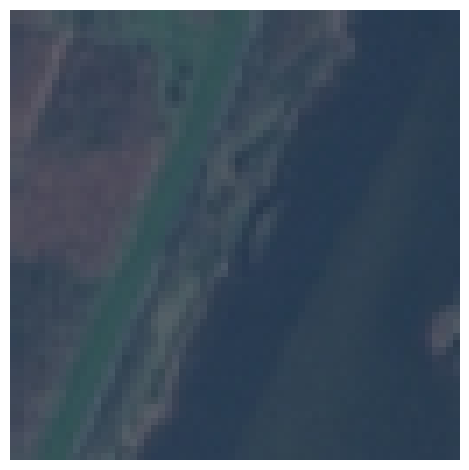

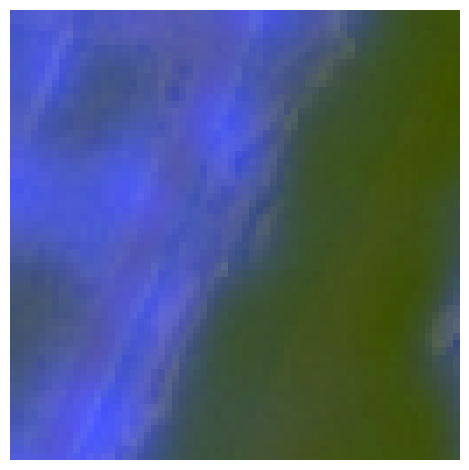

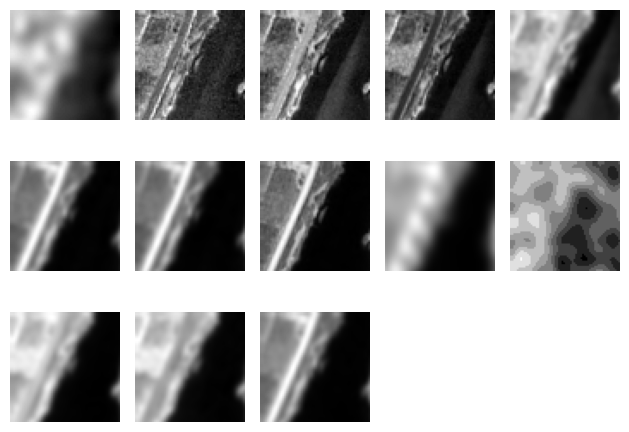

In [20]:
ds = EuroSatDataSet(DATA_PATH_RGB, DATA_PATH_MS)
ds.classes

observation = ds[5000]
ts.show(observation["image"][:3])
ts.show(observation["image"][1:4])
ts.show(observation["image"][3:])

## Models

## Results

## Discussion